### Technical Analysis

Technical analysis is the practice of using historical price movments and statistics, often visualised in charts, to predict future price movement and trends.

In this notebook I will code three of the most popular indicators: Bollinger Bands, the Relative Strength Index (RSI), and the Moving Average Convergence-Divergence (MACD) indicator. I then provide a brief introduction to the Matplotlib finance package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from matplotlib import style
import pandas_datareader.data as web

First read in the stocks historic price data. For the purposes of this notebook I shall limit the data to about 10 years of data.

In [2]:
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime.now()

stock = "GOOG"
df = web.DataReader(stock, 'yahoo', start_date, end_date)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-24,1771.599976,1727.689941,1730.500000,1768.880005,1578000,1768.880005
2020-11-25,1778.540039,1756.540039,1772.890015,1771.430054,1045800,1771.430054
2020-11-27,1804.000000,1772.439941,1773.089966,1793.189941,884900,1793.189941
2020-11-30,1788.064941,1755.000000,1781.183960,1760.739990,1823800,1760.739990
2020-12-01,1824.829956,1769.369995,1774.369995,1798.099976,1736900,1798.099976


Display the historic adjusted close price to visualise the trend.

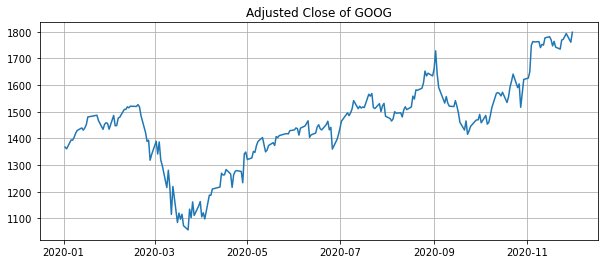

In [3]:
plt.figure(figsize= (10,4))
plt.grid()
plt.title('Adjusted Close of {:s}' .format(stock))
plt.plot(df['Adj Close'])
plt.show()


### Bollinger Bands
Calculate the Moving Average, and the Upper and Lower Bollinger bands and plot them against the closing price. 
I will limit the plot to three months so that it is clearer to see the interaction between the series.

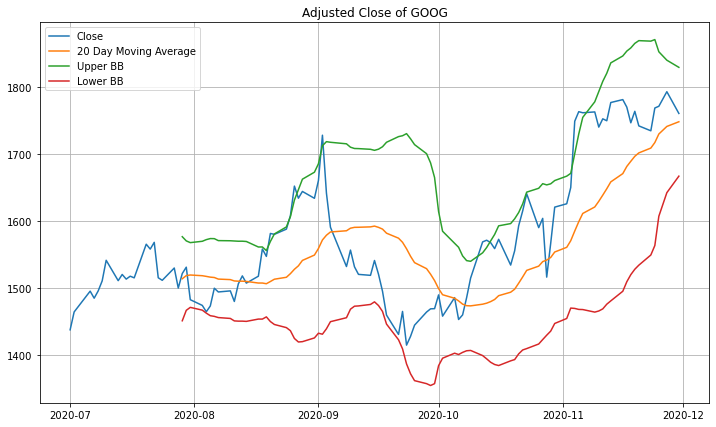

In [4]:
df_bb = df['2020-7' :'2020-11'].copy()
df_bb['MA20'] = df_bb['Adj Close'].rolling(window=20).mean()
df_bb['20_day_stddev'] = df_bb['Adj Close'].rolling(window=20).std()
df_bb['BB Upper'] = df_bb['MA20'] + (2 * df_bb['20_day_stddev'])
df_bb['BB Lower'] = df_bb['MA20'] - (2 * df_bb['20_day_stddev'])

plt.figure(figsize= (12,7))
plt.title('Adjusted Close of {:s}' .format(stock))
plt.grid()
plt.plot(df_bb['Adj Close'], label = 'Close')
plt.plot(df_bb['MA20'], label = '20 Day Moving Average')
plt.plot(df_bb['BB Upper'], label = 'Upper BB')
plt.plot(df_bb['BB Lower'], label = 'Lower BB')
plt.axis('tight')
plt.legend()
plt.show()


At first glance, the price of the stock appears to remain within the upper and lower bands, however if you sold when the stock first breached the upper band, at around mid-August you would have missed an advance of the stock from about 1560 to above 1700, similarly, if you sold at the start of November you would have missed an advance of about 100. Bollinger Bands, like all technical analysis tools, should not be used alone, but should be used alongside other tools to guide your decision making.

### Relative Strength Index
Developed by J. Welles Wilder, the Relative Strength Index (RSI) is a momentum indicator that measures the magnitude and direction of price changes to determine if a stock is overbought or oversold. The RSI oscillates between 0 and 100, the stock is considered overbought if the index is above 70, and considered oversold if the index is below 30.

In [5]:
# caclulate the initial RSI values. note timeseries should have a length of window + 1, 
# as the difference is taken, the first value will be a NAN, so for a window of 14 then 15 price values will be required
def initial_rsi_value(series):    
    diff = series.pct_change()[1:]
    window_size = len(diff)
    
    avg_gain = diff[diff > 0].sum() / window_size
    avg_loss = diff[diff < 0].sum() / window_size  
    
    #  The formula uses a positive value for the average loss.
    return avg_gain,avg_loss * -1

Calculate the RSI. Details of the calculation method can be found on the Relative Strength Index (RSI) page of Investopedia.

In [6]:
window_size = 14 

# initial offset takes into account that the first value in the diff will be nan and so will be removed
initial_offset = window_size + 1
df_rsi = df['2020-7' :'2020-11'].copy()

# The average gain or loss used in the calculation is the average percentage gain or loss during a look-back period.
adj_close_diff = df_rsi['Adj Close'].pct_change()

len_rsi = len(df_rsi) - (initial_offset)
avg_gains = np.zeros((len_rsi,1))
avg_losses = np.zeros((len_rsi,1))

# the avg gain and loss for the first 14 days is calculated differently from the rest of the avg gains/losses 
first_avg_gain, first_avg_loss = initial_rsi_value(df_rsi['Adj Close'][:initial_offset])
avg_gains[0] = first_avg_gain
avg_losses[0] = first_avg_loss

for i in range(1,len_rsi):
    
    current_diff = adj_close_diff[i + initial_offset]
    if current_diff > 0:
        current_gain = current_diff
        current_loss = 0
    else:
        current_gain = 0
        current_loss = current_diff * -1
    
    # Average Gain = [(previous Average Gain) x 13 + current Gain] / 14
    avg_gains[i] = ((avg_gains[i - 1] * (window_size - 1)) + current_gain) /  window_size
    avg_losses[i] = ((avg_losses[i - 1] * (window_size - 1)) + current_loss) /  window_size

# add RSI column to df_rsi
df_rsi = df_rsi.iloc[initial_offset:]
df_rsi = df_rsi.drop(['High','Open','Low','Close','Volume'], axis = 1)
df_rsi['RSI'] = 100 -(100 /(1 + (avg_gains/avg_losses)))

Plot the Relative Strength Index and the Adjusted Closing Price. We can see that for this particular period and stock the RSI was a good indicator of price movement. From Aug 23 to Sep 02 the RSI was above 70, which would indicate that the stock was overbought, hinting at the decline in the price which commenced on Sep 02. At around Nov 3rd the RSI again hit the 70 line indicating a possible overbought scenario, this was reflected in the price as the recent climb in price came to an end.

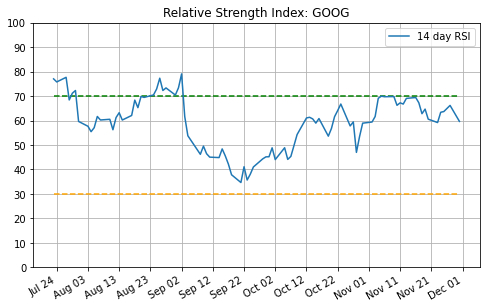

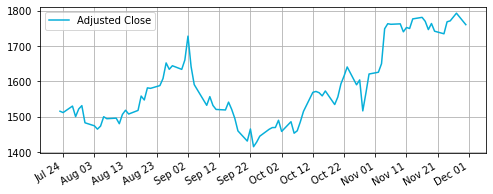

In [7]:
plt.figure(figsize= (8,5))
plt.title('Relative Strength Index: {}' .format(stock))
plt.plot(df_rsi['RSI'], label = '{} day RSI' .format(window_size))
plt.legend()
plt.grid()
plt.hlines(y=70,xmin=df_rsi.index[0],xmax=df_rsi.index[-1],colors='green',linestyles='dashed')
plt.hlines(y=30,xmin=df_rsi.index[0],xmax=df_rsi.index[-1],colors='orange',linestyles='dashed')
plt.ylim(ymax = 100, ymin = 0)
plt.yticks(np.arange(0,110,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.show()

plt.figure(figsize= (8,3))
plt.grid()
plt.plot(df_rsi['Adj Close'], color='#07afd9' ,label='Adjusted Close')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.show()

### MACD
The MACD, an acronym for Moving Average Convergence Divergence, is a popular technical analysis indicator. Created by Gerald Appel in 1979, the popularity of the MACD is owed to its capability to act as both a trend indicator and a momentum indicator.

The MACD is composed of three moving averages, usually set as 12,26, and 9-day. The MACD line is the 12-day Exponential Moving Average (EMA) minus the 26-day EMA. A 9-day EMA of the MACD line acts as a signal line. As the faster moving average is considered to react to price movements faster than than the slower moving average can indicate a shift in trend, with the MACD crossing above the signal line indicating an upward trend and the MACD crossing below the signal line indicating a downward trend. The momentum of the trend can be visualised by the convergence or divergence of the MACD and signal line, this convergence and divergence is often plotted as a histogram. 

One drawback to MACD is that it is created using moving averages and is therefore a lagging indicator. This means that MACD may not be a suitable tool to analysis volitile or non-trending stock, as the indicated trend may be over by the time it is predicted.The charts below indicate the MACD may be useful in analysing GOOG stock. The price declines commencing at the end of Feb and the start of Sep are both indicated by the MACD crossing below the signal line, and the subsequent recoveries are indicated by the MACD crossing above the signal line.   

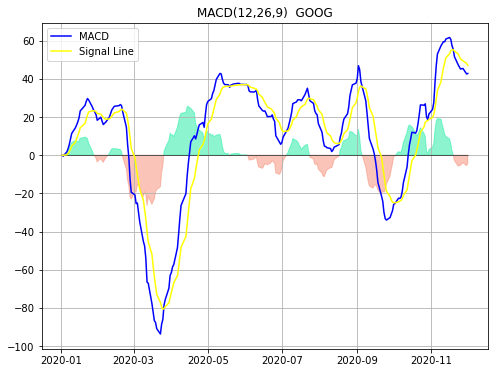

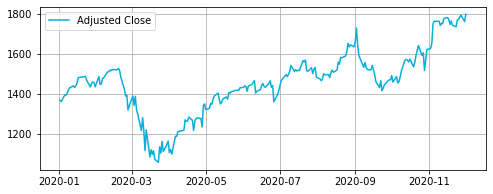

In [8]:
ema12 = df['Adj Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Adj Close'].ewm(span=26, adjust=False).mean()
macd = ema12-ema26
signal = macd.ewm(span=9, adjust=False).mean()
hist = macd - signal

plt.figure(figsize= (8,6))
plt.title('MACD(12,26,9)  {}' .format(stock))
plt.plot( macd, label='MACD', color = 'blue')
plt.plot( signal, label='Signal Line', color='yellow')
plt.legend()
plt.grid()
plt.hlines(y=0,xmin=df.index[0],xmax=df.index[-1],colors='#3a3b39',lw=.8)
plt.fill_between(hist.index,0,hist,where=hist >= 0,color='#1aeda3', interpolate=True,alpha=.5)
plt.fill_between(hist.index,0,hist,where=hist < 0,color='#f78a72', interpolate=True,alpha=.5)

plt.show()


plt.figure(figsize= (8,3))
plt.grid()
plt.plot(df['Adj Close'], color='#07afd9' ,label='Adjusted Close')
plt.legend()
plt.show()



### Matplotlib finance package
While you can manually code technical analysis indicators, there are many purpose built technical analysis packages in Python. Below I plot a Candlestick chart and Renko chart using the Matplotlib finance package. 

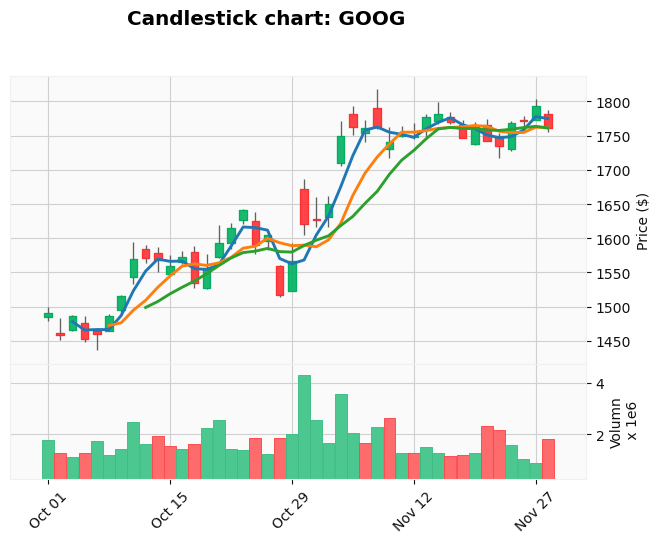

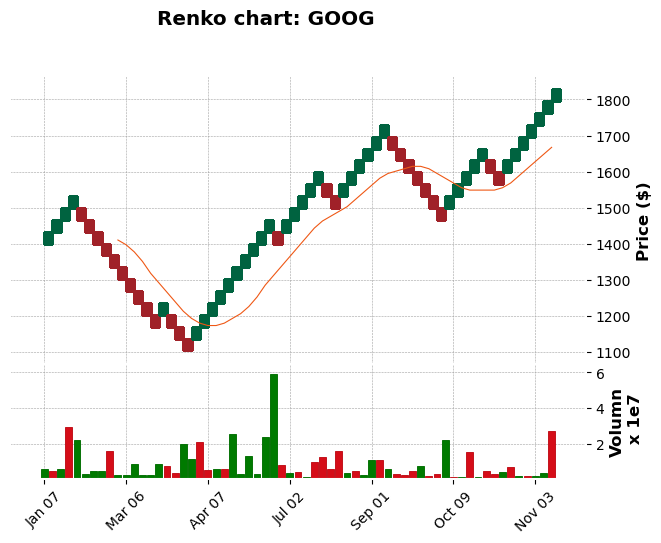

In [9]:
import mplfinance as mpf

# plot candlestick chart
df_ohlc = df['2020-10' :'2020-11']
mpf.plot(df_ohlc, type='candle', style='yahoo',
            title='Candlestick chart: {}' .format(stock),
            ylabel='Price ($)',
            ylabel_lower='Volumn',
            volume=True, 
            mav=(3,6,9))

# plot renko chart
mpf.plot(df, type='renko', style='charles',
            title='Renko chart: {}' .format(stock),
            ylabel='Price ($)',
            ylabel_lower='Volumn',
            volume=True, 
            mav=(10))

